In [2]:
import math
import os  
import time 

from keras._tf_keras.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras._tf_keras.keras.metrics import MeanAbsoluteError, Accuracy, Precision, Recall, MeanSquaredError
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.optimizers import Adam , RMSprop, Nadam, SGD
from keras._tf_keras.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization, Masking, InputLayer, Conv1D, MaxPooling1D, Flatten, TimeDistributed, LayerNormalization, Activation
from keras._tf_keras.keras.regularizers import L1L2, L1, L2
from keras._tf_keras.keras.utils import to_categorical
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder 
from sklearn.tree import DecisionTreeClassifier

from FeatureEngineering import FeatureEngineering as fe 

In [3]:
def create_dataframe_from_data(input_path: str):
    dataframes = []
    for file_name in os.listdir(input_path):
        file_path = os.path.join(input_path, file_name)

        data = np.load(file_path, allow_pickle=True)
        df = pd.DataFrame(data)

        gesture = file_name.split("_")[0]
        gesture_index = int(file_name.split("_")[1].split(".")[0])
        
        # add two new columns to df 
        df["gesture"] = gesture
        df["gesture_index"] = gesture_index

        dataframes.append(df)
        df.sort_values(by="frame", inplace=True)
    
    return pd.concat(dataframes, ignore_index=True) if len(dataframes) > 0 else ValueError("Dataframe is empty")

def create_dict_from_df(df: pd.DataFrame):
    diction = {x: [] for x in np.unique(df["gesture"].values.tolist())}
    for gesture_index, gesture_data in df.groupby("gesture_index"):
        gesture = np.unique(gesture_data["gesture"].values.tolist())[0]
        tmp = diction[gesture] + [gesture_index]
        diction.update({gesture:tmp})
    return diction

def split_dataset(df: pd.DataFrame, target_label: str, additional_targets: list=None, train_ratio=0.8, test_ratio=0.2):
    assert train_ratio + test_ratio == 1.0, "ratios must sum to 1."

    gesture_index_dict = create_dict_from_df(df)

    train_indices = []
    test_indices = []

    for _, indices in gesture_index_dict.items():
        n_train = math.ceil(len(indices) * train_ratio)
        train_indices.extend(indices[:n_train])
        test_indices.extend(indices[n_train:])

    grouped_data = df.groupby("gesture_index")

    train_frames, test_frames = [], []
    for idx in train_indices:
        train_frames.append(grouped_data.get_group(idx))
        
    for idx in test_indices:
        test_frames.append(grouped_data.get_group(idx))

    # Concatenate the dataframes to create the final train and test sets
    train_set = pd.concat(train_frames).reset_index(drop=True)
    test_set = pd.concat(test_frames).reset_index(drop=True)

    # Separate X and y
    X_train = train_set.drop(columns=[target_label])
    y_train = train_set[[target_label] + additional_targets] if additional_targets else train_set[[target_label]]
    X_test = test_set.drop(columns=[target_label])
    y_test = test_set[[target_label] + additional_targets] if additional_targets else test_set[[target_label]]

    return X_train, y_train, X_test, y_test



In [4]:
def augment_model(df: pd.DataFrame, noise_level=0.0, translation_vector=None, rotation_angle=0.0):
    df_augmented = df.copy()

    landmark_columns = [f"{col}" for col in df_augmented.columns if col.startswith(("hx", "hy", "hz", "px", "py", "pz", "lx", "ly", "lz", "rx", "ry", "rz"))]
    num_body_parts = ("h", "p", "l", "r")

    x_columns = [col for col in landmark_columns if any(col.startswith(f'{i}x') for i in num_body_parts)] # this way works because of how i is defined before hand... don't really know
    y_columns = [col for col in landmark_columns if any(col.startswith(f'{i}y') for i in num_body_parts)]
    z_columns = [col for col in landmark_columns if any(col.startswith(f'{i}z') for i in num_body_parts)]

    # Add noise
    if noise_level > 0:
        noise = np.random.normal(0, noise_level, df[x_columns + y_columns + z_columns].shape)
        df_augmented[x_columns + y_columns + z_columns] += noise

    # Apply translation
    if translation_vector is not None:
        for i, col in enumerate(x_columns):
            df_augmented[col] += translation_vector[i % 3]
        for i, col in enumerate(y_columns):
            df_augmented[col] += translation_vector[i % 3]
        for i, col in enumerate(z_columns):
            df_augmented[col] += translation_vector[i % 3]

    # Apply rotation around the Z-axis
    if rotation_angle != 0:
        angle_radians = np.radians(rotation_angle)
        cos_angle = np.cos(angle_radians)
        sin_angle = np.sin(angle_radians)

        for col in x_columns:
            y_col = col.replace('x', 'y')
            df_augmented[col], df_augmented[y_col] = (cos_angle * df_augmented[col] - sin_angle * df_augmented[y_col],
                                                      sin_angle * df_augmented[col] + cos_angle * df_augmented[y_col])
    
    # making the gesture index of the augment different - will be added back to the the df
    # will need to double up on the y train and test as well - in reshape_y_labels
    if "gesture_index" in df_augmented.columns:
        cur_time = time.time_ns()
        df_augmented["gesture_index"] += cur_time

    return df_augmented

def calculate_hand_motion_feature(df: pd.DataFrame, landmark_cols: list):
    df_copy = df.copy()
    print(df_copy.shape)
    s = time.process_time()
    df_elapsed = fe.calculate_elapsed_time(df_copy)    
    print(time.process_time()-s)

    s = time.process_time()
    df_temporal = fe.calculate_temporal_features(df_copy, landmark_cols)
    print(time.process_time()-s)
    # df_stats = fe.calculate_temporal_stats(df_copy, landmark_cols)
    # df_pairwise = fe.calculate_landmark_distances(df_copy, landmark_cols)
    # df_angle = fe.calculate_landmark_angles(df_copy, landmark_cols)
    # df_combined = pd.concat([df_copy, df_angle], axis=1)
    
    # Ensure there are no duplicate columns
    df_combined = df_copy.loc[:,~df_copy.columns.duplicated()]
    return df_combined

In [5]:
def preprocess_pipeline(timeseries_columns, numerical_columns, categorical_columns):
    ts_numerical_transformer = Pipeline(steps=[
        ('imputer', KNNImputer(n_neighbors=5)), # might want to change this out back to the interpolatioon methods
        ('scaler', StandardScaler())
        # ('smoother', FunctionTransformer(lambda x: x.rolling(window=3, min_periods=1).mean())),
        # ('differencing', FunctionTransformer(lambda x: x.diff().fillna(0))),
        # ('lag_features', FunctionTransformer(lambda x: pd.concat([x.shift(i) for i in range(1, 4)], axis=1).fillna(0))),
        # ('rolling_stats', FunctionTransformer(lambda x: pd.concat([x.rolling(window=3).mean(), x.rolling(window=3).std()], axis=1).fillna(0)))
    ])

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="mean")),
        # ('poly', PolynomialFeatures(degree=2, include_bias=False)),  # Polynomial features
        # ('power', PowerTransformer(method='yeo-johnson')),   
        ("normalize", StandardScaler())
        # ('pca', PCA(n_components=10))
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="most_frequent")), # technically this is wrong, would want to fill with a known value - unknown or drop
        ("ohe", OneHotEncoder(sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('ts_num', ts_numerical_transformer, timeseries_columns),
            ('num', numerical_transformer, numerical_columns),
            # ('cat', categorical_transformer, categorical_columns)
        ],
        remainder='passthrough',
        sparse_threshold=0,
        n_jobs=-1
    )
 
    preprocessor.set_output(transform="pandas")
    
    return preprocessor

def reshape_y_labels(df : pd.DataFrame):
    """
    reasoning for this function:
    a single gesture recording can have the same index of n frames.
    This will balloon the size of the (x, y), when in reality it's much
    smaller. This will goo through each frame, and if the continuous pattern
    breaks (e.g. 12 -> 0), everything before "12" will be removed keeping only
    one instance of the gesture
    """
    
    unique_sequences = []
    for _, group in df.groupby("gesture_index"):
        reset_points = group['frame'].diff().fillna(1) < 0
        if reset_points.any():
            unique_sequences.append(group[reset_points])
        else:
            # If no reset points, consider the whole group as unique
            unique_sequences.append(group.iloc[[0]])

    # Concatenate unique sequences
    df_unique = pd.concat(unique_sequences).reset_index(drop=True)
    df_doubled = pd.concat([df_unique, df_unique], axis=0).reset_index(drop=True)
    return pd.factorize(df_doubled["gesture"])

In [12]:
def create_cnn(input_shape, output_units):
    model = Sequential()
    model.add(InputLayer(shape=input_shape))
    model.add(Conv1D(filters=64, kernel_size=3, activation="relu"))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.4))

    model.add(Conv1D(filters=128, kernel_size=3, activation="relu"))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    model.add(Flatten())

    model.add(Dense(100, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(units=len(np.unique(output_units)), activation="softmax", kernel_regularizer=L2(0.00001), bias_regularizer=L2(0.0001)))
    
    model.compile(optimizer=SGD(learning_rate=0.001, weight_decay=1e-6, momentum=0.97, nesterov=True), loss="categorical_crossentropy", metrics=["categorical_accuracy"])
    model.summary()
    return model

In [6]:
def create_lstm(input_shape, output_units):
    model = Sequential()
    model.add(InputLayer(shape=input_shape))
    model.add(LSTM(96, return_sequences=True, activation='relu', kernel_regularizer=L2(0.0001)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(LSTM(128, return_sequences=True, activation='relu', kernel_regularizer=L2(0.0001)))
    model.add(LSTM(64, return_sequences=False, activation='relu', kernel_regularizer=L2(0.0001)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(units=len(np.unique(output_units)), activation="softmax", kernel_regularizer=L2(0.00001), bias_regularizer=L2(0.0001)))
    model.compile(optimizer=SGD(learning_rate=0.001, weight_decay=1e-6, momentum=0.97, nesterov=True), loss="categorical_crossentropy", metrics=["categorical_accuracy"])
    return model

In [8]:
input_path = "C:\\Users\\Gen3r\\Documents\\capstone\\ml_model\\data\\data_3"

dataframe = create_dataframe_from_data(input_path)
X_train, y_train, X_test, y_test = split_dataset(dataframe, "gesture", ["frame", "gesture_index"])

landmark_columns = [f"{col}" for col in dataframe.columns if col.startswith(("hx", "hy", "hz", "px", "py", "pz", "lx", "ly", "lz", "rx", "ry", "rz"))]
categorical_columns = ["gesture_index"]
numerical_columns = ["frame", "frame_rate", "frame_width", "frame_height"] + [f"{col}" for col in dataframe.columns if col.startswith("pose_visibility")]
derived_features =  ['elapsed_time'] + \
                    [f"{feat}_{col}" for feat in ["velocity", "acceleration", "jerk"] for col in landmark_columns if col.startswith(("lx", "ly", "lz", "rx", "ry", "rz"))]
time_series_columns = landmark_columns + derived_features     
res = [item for item in landmark_columns if item.startswith(("r", "l"))]

isOn = False

if not os.path.exists("train.csv") or isOn == True :
    X_train_augmented = augment_model(X_train, noise_level=0.05, translation_vector=[0.6, -0.5, 0.05], rotation_angle=45)
    X_test_augmented = augment_model(X_test, noise_level=0.05, translation_vector=[0.6, -0.5, 0.05], rotation_angle=45)

    X_train_combined = pd.concat([X_train, X_train_augmented], axis=0, ignore_index=True)
    X_test_combined = pd.concat([X_test, X_test_augmented], axis=0, ignore_index=True)
    
    X_train_fe = calculate_hand_motion_feature(X_train_combined, res)
    X_test_fe = calculate_hand_motion_feature(X_test_combined, res)

    X_train_fe.to_csv("train.csv", index=False)
    X_test_fe.to_csv("test.csv", index=False)
    print("saved")
else:
    X_train_fe = pd.read_csv("train.csv")
    X_test_fe = pd.read_csv("test.csv")
    print("imported")

preprocessor = preprocess_pipeline(time_series_columns, numerical_columns, categorical_columns)
X_train_transformed = preprocessor.fit_transform(X_train_fe)
X_test_transformed = preprocessor.transform(X_test_fe) # need to redo that gesture_index thing

y_train_reshaped, labels = reshape_y_labels(y_train)
y_test_reshaped, _ = reshape_y_labels(y_test)
class_labels = labels


y_train_one_hot = to_categorical(y_train_reshaped, num_classes=len(labels))
y_test_one_hot = to_categorical(y_test_reshaped, num_classes=len(labels))

print(X_train_fe.shape, X_test_fe.shape)
X_train_reshaped = np.reshape(X_train_fe, ((X_train_fe.shape[0]//30), 30, X_train_fe.shape[1]))
X_test_reshaped = np.reshape(X_test_fe, ((X_test_fe.shape[0]//30), 30, X_train_fe.shape[1]))

print("before lstm:",X_train_reshaped.shape, X_test_reshaped.shape, y_train_one_hot.shape, y_test_one_hot.shape)



imported
(16740, 2046) (4140, 2046)
before lstm: (558, 30, 2046) (138, 30, 2046) (558, 5) (138, 5)


(16740, 2019) (4140, 2019) (16740,) (4140,)
KNN Training Accuracy: 1.0
KNN Test Accuracy: 0.9782608695652174
Classification Report for KNN on Test Data:
               precision    recall  f1-score   support

    ALL-DONE       1.00      1.00      1.00       840
       DRINK       1.00      1.00      1.00       840
         EAT       0.90      1.00      0.95       780
        MORE       1.00      0.89      0.94       840
   THANK-YOU       1.00      1.00      1.00       840

    accuracy                           0.98      4140
   macro avg       0.98      0.98      0.98      4140
weighted avg       0.98      0.98      0.98      4140



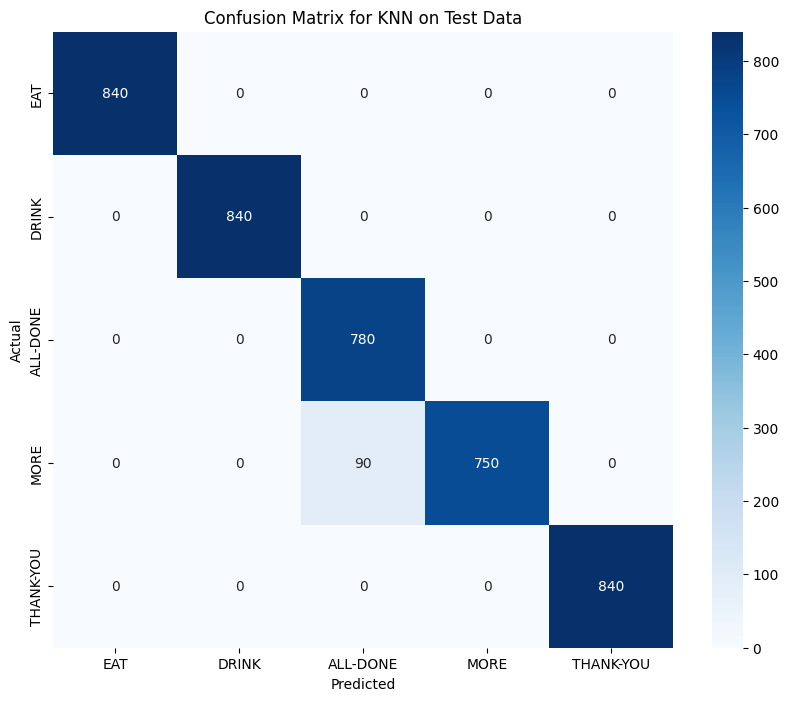

In [93]:
# knn model
def y_labels_std(df: pd.DataFrame):
    df = pd.concat([df, df], axis=0).reset_index(drop=True)
    return df["gesture"]

y_train_knn = y_labels_std(y_train)
y_test_knn = y_labels_std(y_test)

# Initialize the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the model
knn.fit(X_train_transformed, y_train_knn)

# Predict
y_train_pred = knn.predict(X_train_transformed)
y_test_pred = knn.predict(X_test_transformed)

print(X_train_transformed.shape, X_test_transformed.shape, y_train_knn.shape, y_test_knn.shape)
# Evaluate the model
print("KNN Training Accuracy:", accuracy_score(y_train_knn, y_train_pred))
print("KNN Test Accuracy:", accuracy_score(y_test_knn, y_test_pred))
print("Classification Report for KNN on Test Data:\n", classification_report(y_test_knn, y_test_pred))

# Confusion Matrix
cm = confusion_matrix(y_test_knn, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for KNN on Test Data')
plt.show()

Decision Tree Training Accuracy: 1.0
Decision Tree Test Accuracy: 0.9628019323671497
Classification Report for Decision Tree on Test Data:
               precision    recall  f1-score   support

    ALL-DONE       0.91      0.99      0.95       840
       DRINK       1.00      1.00      1.00       840
         EAT       0.96      0.99      0.98       780
        MORE       0.97      0.99      0.98       840
   THANK-YOU       0.98      0.85      0.91       840

    accuracy                           0.96      4140
   macro avg       0.96      0.96      0.96      4140
weighted avg       0.96      0.96      0.96      4140



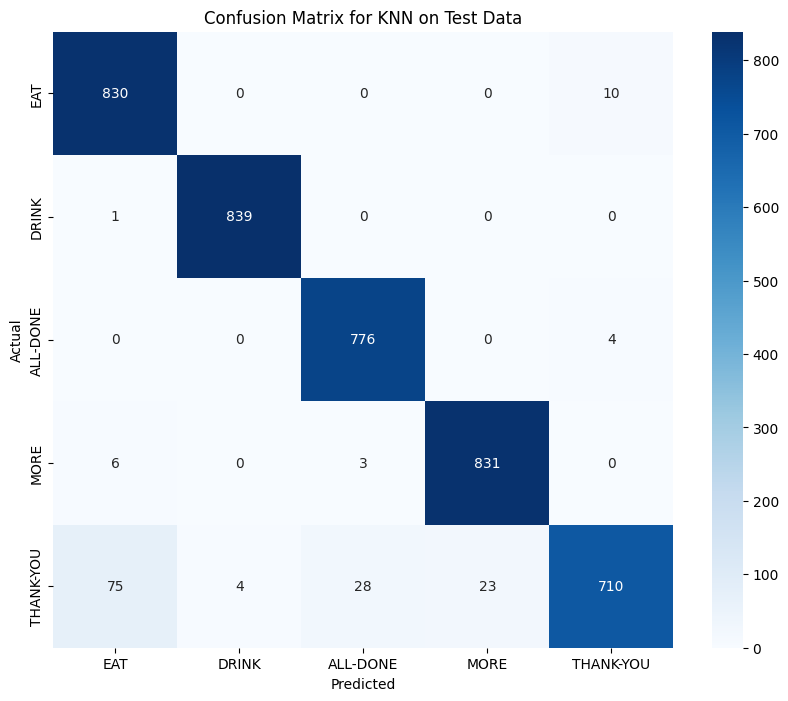

In [64]:
# Initialize the Decision Tree classifier
dt = DecisionTreeClassifier()

# Fit the model
dt.fit(X_train_transformed, y_train_knn)

# Predict
y_train_pred = dt.predict(X_train_transformed)
y_test_pred = dt.predict(X_test_transformed)

# Evaluate the model
print("Decision Tree Training Accuracy:", accuracy_score(y_train_knn, y_train_pred))
print("Decision Tree Test Accuracy:", accuracy_score(y_test_knn, y_test_pred))
print("Classification Report for Decision Tree on Test Data:\n", classification_report(y_test_knn, y_test_pred))

# Confusion Matrix
cm = confusion_matrix(y_test_knn, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for KNN on Test Data')
plt.show()

In [14]:
# cnn needs sequence len and num features
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)	
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-10)	
model_checkpoint = ModelCheckpoint(filepath=f"checkpoints/checkpoint{time.time()}.model.keras", mode="max", monitor="val_accuracy", save_best_only=True)
input =  (X_train_reshaped.shape[1], X_train_reshaped.shape[2])
model = create_cnn(input, labels)
history = model.fit(
    X_train_reshaped, y_train_one_hot, 
    epochs=100,  
    validation_split=0.20,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

test_loss, test_acc = model.evaluate(X_test_reshaped, y_test_one_hot)	
print(f'Test Accuracy: {test_acc} || Test Loss: {test_loss}')

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 28, 64)         │       392,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 12, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        76,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 495,005 (1.89 MB)

 Trainable params: 495,005 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
14/14 - 2s - 141ms/step - categorical_accuracy: 0.1726 - loss: 16075360935723472233955328.0000 - val_categorical_accuracy: 0.2411 - val_loss: 44520917062306805045002240.0000 - learning_rate: 0.0010
Epoch 2/100
14/14 - 0s - 16ms/step - categorical_accuracy: 0.1973 - loss: 76392551225133570065432576.0000 - val_categorical_accuracy: 0.1875 - val_loss: 113892512977464022225911808.0000 - learning_rate: 0.0010
Epoch 3/100
14/14 - 0s - 20ms/step - categorical_accuracy: 0.2040 - loss: 143886835830967421460545536.0000 - val_categorical_accuracy: 0.1875 - val_loss: 176441354624344858799636480.0000 - learning_rate: 0.0010
Epoch 4/100
14/14 - 0s - 24ms/step - categorical_accuracy: 0.2040 - loss: 199937968675208695008722944.0000 - val_categorical_accuracy: 0.1875 - val_loss: 224631204567389996121587712.0000 - learning_rate: 5.0000e-04
Epoch 5/100
14/14 - 0s - 25ms/step - categorical_accuracy: 0.2040 - loss: 241639084156606129001988096.0000 - val_categorical_accuracy: 0.1875 - val_loss: 

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)	
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-10)	
model_checkpoint = ModelCheckpoint(filepath=f"checkpoints/checkpoint{time.time()}.model.keras", mode="max", monitor="val_accuracy", save_best_only=True)

input =  (X_train_reshaped.shape[1], X_train_reshaped.shape[2])
model = create_lstm(input, labels)
history = model.fit(
    X_train_reshaped, y_train_one_hot, 
    epochs=100,  
    validation_split=0.20,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

test_loss, test_acc = model.evaluate(X_test_reshaped, y_test_one_hot)	
print(f'Test Accuracy: {test_acc} || Test Loss: {test_loss}')

Epoch 1/100
14/14 - 8s - 587ms/step - categorical_accuracy: 0.1794 - loss: 1.7211 - val_categorical_accuracy: 0.1875 - val_loss: 1.7253 - learning_rate: 0.0010
Epoch 2/100
14/14 - 1s - 102ms/step - categorical_accuracy: 0.2018 - loss: 1.7105 - val_categorical_accuracy: 0.1875 - val_loss: 1.9128 - learning_rate: 0.0010
Epoch 3/100
14/14 - 2s - 177ms/step - categorical_accuracy: 0.1883 - loss: 1.7109 - val_categorical_accuracy: 0.1875 - val_loss: 1.7179 - learning_rate: 0.0010
Epoch 4/100
14/14 - 2s - 109ms/step - categorical_accuracy: 0.2197 - loss: 1.7065 - val_categorical_accuracy: 0.1875 - val_loss: 1.7087 - learning_rate: 0.0010
Epoch 5/100
14/14 - 1s - 101ms/step - categorical_accuracy: 0.2287 - loss: 1.7055 - val_categorical_accuracy: 0.1875 - val_loss: 1.7087 - learning_rate: 0.0010
Epoch 6/100
14/14 - 1s - 67ms/step - categorical_accuracy: 0.1951 - loss: 1.7074 - val_categorical_accuracy: 0.1875 - val_loss: 1.7093 - learning_rate: 0.0010
Epoch 7/100
14/14 - 1s - 66ms/step - cate

3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step WARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001CC95A9DE10> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step
labels: Index(['EAT', 'DRINK', 'ALL-DONE', 'MORE', 'THANK-YOU'], dtype='object')


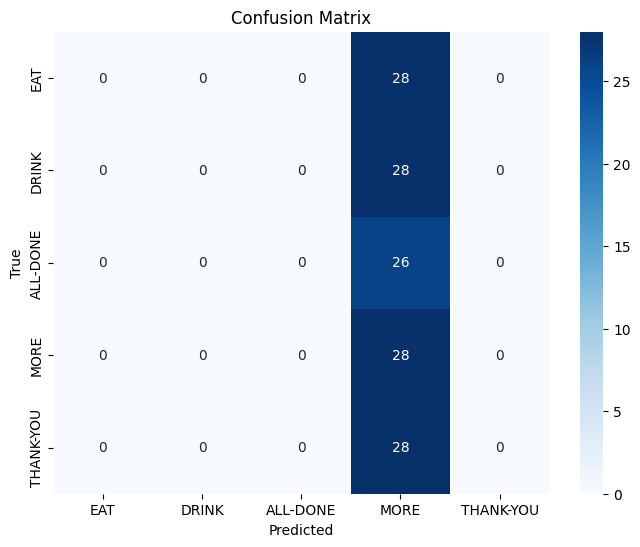

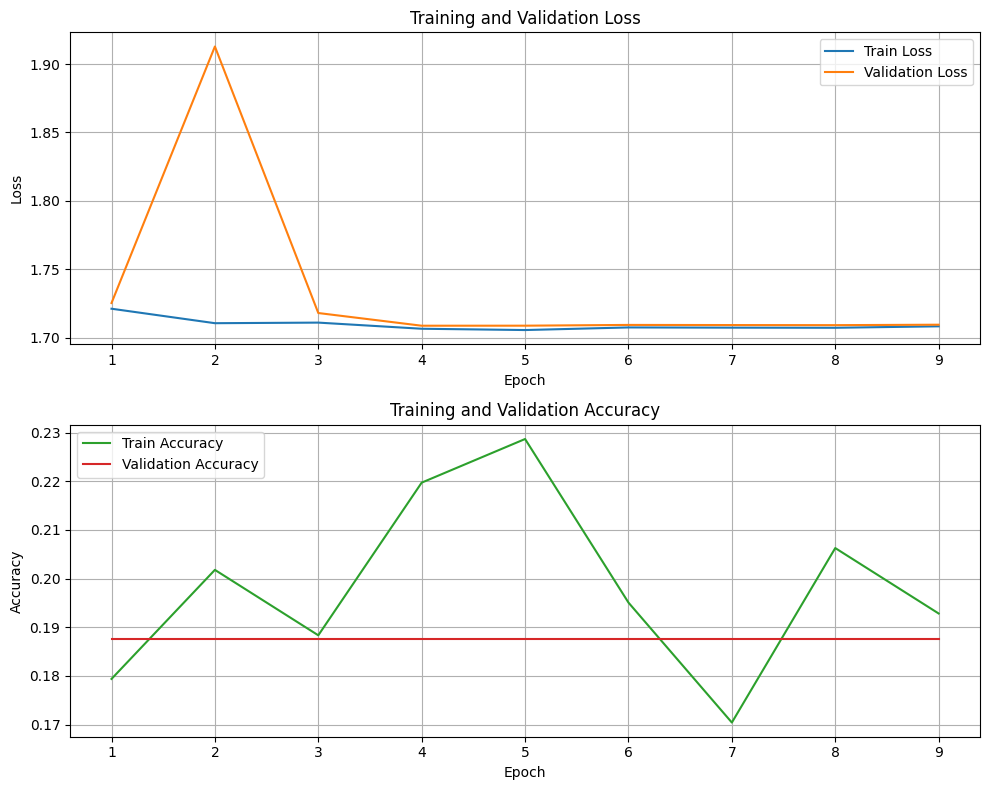

In [14]:
y_pred = model.predict(X_test_reshaped)
y_test_labels = np.argmax(y_test_one_hot, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)
labels = np.unique(np.concatenate((y_test_labels, y_pred_labels)))
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=labels)
print("labels:", class_labels)


# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.ion()
plt.show()

# Extracting the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
epochs = range(1, len(train_loss) + 1)

# Create a figure with two subplots (2 rows, 1 column)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot training and validation loss
ax1.plot(epochs, train_loss, label='Train Loss', color='tab:blue')
ax1.plot(epochs, val_loss, label='Validation Loss', color='tab:orange')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend(loc='upper right')
ax1.grid(True)

# Plot training and validation accuracy
ax2.plot(epochs, train_acc, label='Train Accuracy', color='tab:green')
ax2.plot(epochs, val_acc, label='Validation Accuracy', color='tab:red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend(loc='upper left')
ax2.grid(True)

# Adjust layout to prevent overlap
fig.tight_layout()

# Display the plots
plt.show()